## 🎯#2. 실습 : qml 

QSVM 을 이용한 머신 러닝 모델을 적용하였습니다.
- 샘플링 갯수, PCA 차수 축소


### 🙏 참고한 자료

In [34]:
# !pip install qiskit-machine-learning --upgrade
# !pip show qiskit-machine-learning
# !pip install qiskit-aer

In [36]:
# ▶ 필요한 패키지 설치 (최초 1회만)
# pip install qiskit qiskit-machine-learning scikit-learn pandas numpy matplotlib

# from qiskit.utils import algorithm_globals
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.kernels import FidelityQuantumKernel#QuantumKernel
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
# from qiskit import BasicAer
from qiskit_aer import AerSimulator
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler, StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute, BaseStateFidelity

# 2048차원 fingerprint, label 데이터를 불러오기
X_features = np.load("X_features.npy")
y = np.load("y_labels.npy")



In [41]:

# 1. 샘플 수 제한 (양자 커널은 느림)
X_small = X_features[:300]
y_small = y[:300]

# 2. PCA로 차원 축소 (2차원)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_small)

# 3. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_small, test_size=0.2, random_state=42)

# 4. 양자 feature map 설정 (2-qubit ZZFeatureMap)
feature_map = PauliFeatureMap(feature_dimension=2, reps=3)

# 5. Quantum kernel 정의
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler)#qiskit1.0 이상부터는 AerSimulator(method="statevector")으로 백엔드를 지정하는 대신에, StatevectorSampler를 샢플러로 쓰면 
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity = fidelity)

# 6. QSVM 학습용 커널 행렬 생성
kernel_train = quantum_kernel.evaluate(x_vec=X_train)
kernel_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

# 7. SVM 학습 (precomputed kernel 사용)
qsvm = SVC(kernel="precomputed")
qsvm.fit(kernel_train, y_train)


SVC(kernel='precomputed')

정확도46.67%
              precision    recall  f1-score   support

           0       0.45      0.61      0.52        28
           1       0.50      0.34      0.41        32

    accuracy                           0.47        60
   macro avg       0.47      0.48      0.46        60
weighted avg       0.48      0.47      0.46        60



,precision,recall,f1-score,support
0,0.45,0.61,0.52,28.00
1,0.50,0.34,0.41,32.00
accuracy,0.47,0.47,0.47,0.47
macro avg,0.47,0.48,0.46,60.00
weighted avg,0.48,0.47,0.46,60.00


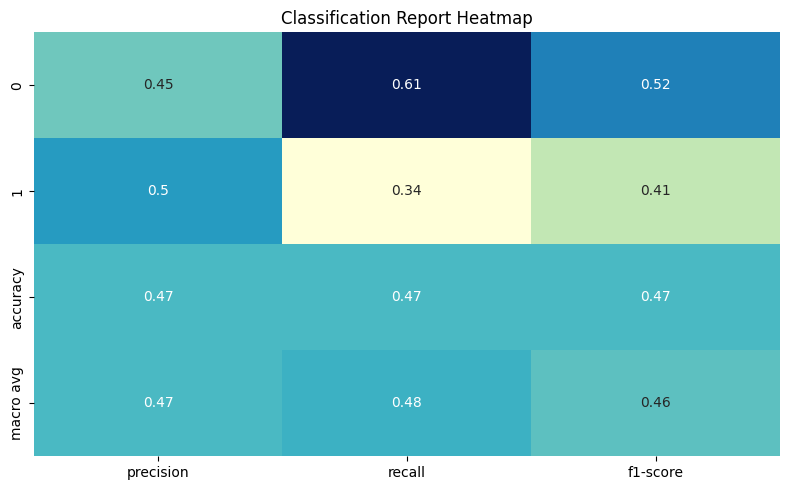

In [ ]:
# 8. 예측 및 평가
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
y_pred = qsvm.predict(kernel_test)

accuracy = accuracy_score(y_test, y_pred)
print("정확도{:.2f}%".format(accuracy*100))

report_dict = classification_report(y_test, y_pred,output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().round(2)
display(df_report)
# 'support'는 숫자 범위가 달라서 제외
df_plot = df_report.drop(columns=['support'], errors='ignore')
# 히트맵 그리기
plt.figure(figsize=(8, 5))
sns.heatmap(df_plot.iloc[:-1], annot=True, cmap="YlGnBu", cbar=False)
plt.title("Classification Report Heatmap")
plt.tight_layout()
plt.savefig("classification_report_heatmap.png", dpi=300)
plt.show()
df_report.to_csv("creport_DL.csv")



In [ ]:
# 3.1. 정확도
from sklearn.metrics import roc_curve, auc

y_proba = qsvm.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # 랜덤 분류 기준선
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DL ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("image/DL_roc_curve.png", dpi=300)
plt.show()


ValueError: X has 2 features, but SVC is expecting 240 features as input.

In [38]:
# print(X_features)
# print(y)

정확도46.67%


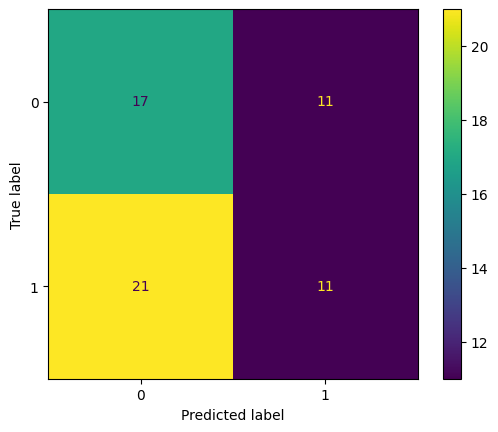

<Figure size 640x480 with 0 Axes>

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
plt.savefig("image/hiv_QML_pca2_sp300_Paulif_fk_score48.png")


## ✍️ 배운 점
- 

## 📌 다음 목표
- 

## 💭궁금한 점 및 추가 정보

#### 1. BasicAer vs Aer 차이점
| 항목 | `BasicAer` | `Aer` |
| -- | -- | -- |
|  패키지 | `qiskit.providers.basicaer` | `qiskit-aer` (별도 설치 필요) |
| 시뮬레이터 종류 | 간단한 기본 시뮬레이터 | 고성능 고급 시뮬레이터 |
| 설치 여부 | Qiskit 기본 포함 | 별도 설치 필요 (`pip install qiskit-aer`) |
| 성능 | 느리고 기능 제한 | 빠르고 다양한 옵션 제공 (노이즈, GPU 등) |
| 지원 백엔드 | `statevector_simulator`, `qasm_simulator` | `aer_simulator_statevector`, `aer_simulator` 등 |
| 활용도 | 단순 실습용 | 실제 연구, 튜닝, 실전 실험용 |
| 유지보수 상태  | 거의 업데이트 없음 | 활발히 개발 중 |


